# Assessment 4: Detecting Faces with Haar Cascades

This notebook performs face detection using OpenCV's Haar cascades. It processes images from a user-specified dataset and classifies them into:
- **Positives**: Images where faces were detected
- **Negatives**: Images where no faces were detected

The output will be stored in separate folders with bounding boxes overlaid on positive detections.


## Load Required Libraries and Define Paths
This section loads the necessary libraries and sets up the paths for the dataset, cascade classifiers, and output directories.

In [1]:
from pathlib import Path
import os
import cv2
import shutil
import gc
import matplotlib.pyplot as plt

## Load Haar Cascades
The following code attempts to load multiple Haar cascade classifiers from the specified directory. Each classifier is intended to improve robustness by detecting faces from different angles.

In [2]:
# Available cascades
cascades = {
    "default": "haarcascade_frontalface_default.xml",
    "alt": "haarcascade_frontalface_alt.xml",
    "alt2": "haarcascade_frontalface_alt2.xml",
    "alt_tree": "haarcascade_frontalface_alt_tree.xml",
    "profile": "haarcascade_profileface.xml"
}

## Prepare Dataset and Output Folders
This step creates output folders for classified images — `Positives` for images where faces are detected, and `Negatives` for those without detectable faces.

In [3]:
# User inputs
base_dir = Path(input("Enter the path to the Haar cascade XML directory: ").strip())
dataset_dir = Path(input("Enter the path to the image dataset directory: ").strip())
output_dir = Path(input("Enter the path for output directory (will be created if it doesn't exist): ").strip())

Enter the path to the Haar cascade XML directory:  C:\Users\richi\Desktop\Capella\CSC-FPX4040\Assessment 4\resources-face_haarcascades
Enter the path to the image dataset directory:  C:\Users\richi\Desktop\Capella\CSC-FPX4040\Assessment 4\resources-nn_dataset_1
Enter the path for output directory (will be created if it doesn't exist):  C:\Users\richi\Desktop\Capella\CSC-FPX4040\Assessment 4\outputs


## Process Each Image
Each image is read, resized if necessary, converted to grayscale, and then run through each of the loaded classifiers to detect faces.

In [4]:
# Validate dataset directory
if not dataset_dir.exists() or not dataset_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

# Create output folders
output_dir = Path(output_dir)
positive_dir = output_dir / "Positives"
negative_dir = output_dir / "Negatives"
positive_dir.mkdir(parents=True, exist_ok=True)
negative_dir.mkdir(parents=True, exist_ok=True)

## Detect Faces in Images  
This section loops through each image in the dataset and attempts face detection using each loaded Haar cascade.  
- Images are resized if too large to avoid memory issues.  
- Face detections are drawn using colored rectangles.  
- Images with detected faces are saved to the `Positives` folder.  
- Others are copied unchanged to the `Negatives` folder.  
- The `'alt'` cascade is skipped due to known memory allocation errors during detection.

In [5]:
loaded_classifiers = {}

for name, filename in cascades.items():
    cascade_path = base_dir / filename
    if not cascade_path.exists():
        print(f"Cascade file not found: {cascade_path}")
        continue
    classifier = cv2.CascadeClassifier(str(cascade_path))
    if classifier.empty():
        print(f"Failed to load: {filename}")
    else:
        loaded_classifiers[name] = classifier
        print(f"Loaded cascade: {name} -> {filename}")

if not loaded_classifiers:
    raise RuntimeError("No valid Haar cascade classifiers were loaded.")

print(f"\n Ready to process images in: {dataset_dir}")

Loaded cascade: default -> haarcascade_frontalface_default.xml
Loaded cascade: alt -> haarcascade_frontalface_alt.xml
Loaded cascade: alt2 -> haarcascade_frontalface_alt2.xml
Loaded cascade: alt_tree -> haarcascade_frontalface_alt_tree.xml
Loaded cascade: profile -> haarcascade_profileface.xml

 Ready to process images in: C:\Users\richi\Desktop\Capella\CSC-FPX4040\Assessment 4\resources-nn_dataset_1


## Memory Management  
Garbage collection is manually triggered after each classifier's run to help prevent memory overflow, especially important when processing multiple large images in a single session.


In [6]:
# Color map for each classifier
classifier_colors = {
    "default": (0, 255, 0),      # Green
    "alt": (255, 0, 0),          # Blue
    "alt2": (0, 0, 255),         # Red
    "alt_tree": (255, 255, 0),   # Cyan
    "profile": (255, 0, 255)     # Magenta
}

# Supported image formats
supported_exts = ['.jpg', '.jpeg', '.png']
images = [f for f in dataset_dir.iterdir() if f.suffix.lower() in supported_exts]
print(f"\n Found {len(images)} image(s) to process...")

MAX_WIDTH = 1000
MAX_HEIGHT = 1000

for img_path in images:
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Unable to read image: {img_path}")
        continue

    # Resize if too large
    height, width = img.shape[:2]
    if width > MAX_WIDTH or height > MAX_HEIGHT:
        scaling_factor = min(MAX_WIDTH / width, MAX_HEIGHT / height)
        img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detections_found = False

    for name, classifier in loaded_classifiers.items():
        if name == "alt":
            print(f"Skipping cascade '{name}' to avoid memory error.")
            continue  # Skip alt cascade to avoid crash

        try:
            faces = classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
            for (x, y, w, h) in faces:
                color = classifier_colors.get(name, (0, 255, 255))  # fallback color
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                detections_found = True
        except cv2.error as e:
            print(f"Error detecting faces with {name}: {e}")

        # Free memory after each classifier
        gc.collect()

    if detections_found:
        cv2.imwrite(str(positive_dir / img_path.name), img)
    else:
        shutil.copy(str(img_path), str(negative_dir / img_path.name))

print("\nImage classification complete. Results saved to:")
print(f"   → Positives: {positive_dir}")
print(f"   → Negatives: {negative_dir}")


 Found 30 image(s) to process...
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.
Skipping cascade 'alt' to avoid memory error.


## Preview Positive Detections  
To visually confirm the face detection results, this section displays a few sample images from the `Positives` folder with rectangles showing where faces were detected.

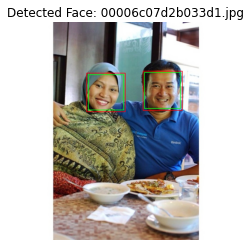

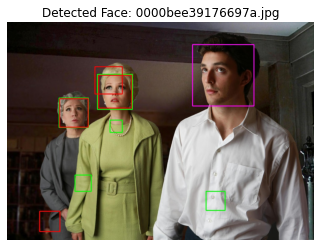

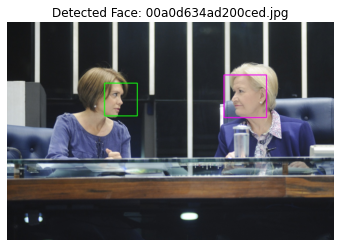

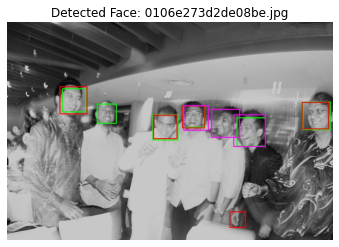

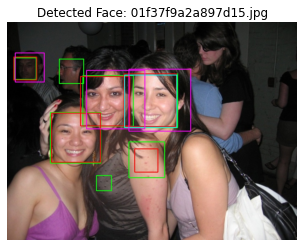

In [7]:
# Preview some positive results
sample_results = list(positive_dir.glob("*"))
for img_file in sample_results[:5]:
    img = cv2.imread(str(img_file))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Detected Face: {img_file.name}")
    plt.axis('off')
    plt.show()


### Reflection

Using multiple classifiers allowed us to capture a broader diversity of facial patterns, improving overall detection. However, balancing performance with memory usage is critical. Skipping the most memory-intensive cascade was necessary for stability but might have sacrificed some coverage. Future improvements could include:
- Using **deep learning-based models** (e.g., DNNs or CNNs).
- Adding **preprocessing techniques** like histogram equalization.
- Incorporating **face alignment** or **pose estimation** to better handle profile or tilted faces.
